**References:** 

1. [DEAP: A Database for Emotion Analysis using Physiological Signals](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/doc/tac_special_issue_2011.pdf)

2. [Online Prediction of Driver Distraction Based on Brain Activity Patterns](https://www.researchgate.net/publication/267154789_Online_Prediction_of_Driver_Distraction_Based_on_Brain_Activity_Patterns)

3. [Emotion Recognition with Machine Learning Using
EEG Signals](https://arxiv.org/pdf/1903.07272.pdf)

4. [EEG Correlates of Different Emotional States Elicited during Watching Music Videos](https://www.researchgate.net/publication/221622214_EEG_Correlates_of_Different_Emotional_States_Elicited_during_Watching_Music_Videos)

5. [The Effect of Transcranial Magnetic Stimulation on Brain Electrical Activity](https://www.researchgate.net/publication/267811728_THE_EFFECT_OF_TRANSCRANIAL_MAGNETIC_STIMULATION_ON_BRAIN_BIOELECTRICAL_ACTIVITY)

**Original dataset:** 

The dataset is mounted from our Google Drive and could be downloaded [here](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/download.html). 

In [1]:
import os
import time
import pickle
import pandas as pd
import numpy as np

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore

from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

# Load dataset
The EEG and peripheral physiological signals of 32 participants were recorded as each watched 40 music videos. Participants rated each video in terms of the levels of arousal, valence, dominance, and liking. The data was downsampled (to 128Hz), preprocessed and segmented in pickled Python formats.

In [2]:
# Function to load data from each participant file
def read_eeg_signal_from_file(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p

In [3]:
# Load only 22/32 participants with frontal videos recorded
files = []
for n in range(1, 23): 
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)
print(files)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']


Each participant file contains two arrays: a "data" array (40 trials x 40 channels x 8064 data) and a "label" array (40 trials x 4 subjective ratings: valence, arousal, dominance, liking). We combine the data files into 2 new arrays with 880 trials for 22/32 participants (participants with frontal videos recorded).

In [24]:
# 22x40 = 880 trials for 22 participants
labels = []
data = []

for i in files: 
  filename = "C:/Users/thiag/OneDrive - Georgia Institute of Technology/DEAP/data_preprocessed_python/s" + i + ".dat"
  trial = read_eeg_signal_from_file(filename)
  labels.append(trial['labels'])
  data.append(trial['data'])
   
    
# Re-shape arrays into desired shapes
labels = np.array(labels)
print("Labels - previous: ", labels.shape) # trial x label
labels = labels.flatten()
labels = labels.reshape(880, 4)

data = np.array(data)
print("Data - previous: ", data.shape) # trial x channel x data   
data = data.flatten()
data = data.reshape(880, 40, 8064)

Labels - previous:  (22, 40, 4)
Data - previous:  (22, 40, 40, 8064)


In [25]:
# Double-check the new arrays
print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (880, 4)
Data:  (880, 40, 8064)


# Explore and pre-process data

## Labels

#### Get Valence and Arousal ratings
Valence describes the extent to which an emotion is positive or negative, whereas Arousal refers to its intensity, i.e., the strength of the associated emotional state.

In [6]:
# Only extract Valence and Arousal ratings
df_label_ratings = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1]})
print(df_label_ratings.describe())

          Valence     Arousal
count  880.000000  880.000000
mean     5.218034    5.238898
std      2.093837    1.879631
min      1.000000    1.000000
25%      3.650000    3.895000
50%      5.040000    5.490000
75%      7.040000    6.795000
max      9.000000    9.000000


In [7]:
print(df_label_ratings.head(15))

    Valence  Arousal
0      7.71     7.60
1      8.10     7.31
2      8.58     7.54
3      4.94     6.01
4      6.96     3.92
5      8.27     3.92
6      7.44     3.73
7      7.32     2.55
8      4.04     3.29
9      1.99     4.86
10     2.99     2.36
11     2.71     2.77
12     1.95     3.12
13     4.18     2.24
14     3.17     8.08


<AxesSubplot:>

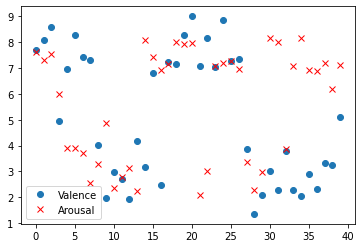

In [8]:
# Plot the first 40 data rows (first participant)
df_label_ratings.iloc[0:40].plot(style=['o','rx'])

#### Check positive/negative cases

The combinations of Valence and Arousal can be converted to emotional states: High Arousal Positive Valence (Excited, Happy), Low Arousal Positive Valence (Calm, Relaxed), High Arousal Negative Valence (Angry, Nervous), and Low Arousal Negative Valence (Sad, Bored).

In [9]:
# High Arousal Positive Valence dataset
df_hahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Positive Valence dataset
df_lahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]
# High Arousal Negative Valence dataset
df_halv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Negative Valence dataset
df_lalv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]

In [10]:
# Check nummber of trials per each group
print("Positive Valence:", str(len(df_hahv) + len(df_lahv)))
print("Negative Valence:", str(len(df_halv) + len(df_lalv)))
print("High Arousal:", str(len(df_hahv) + len(df_halv)))
print("Low Arousal:", str(len(df_lahv) + len(df_lalv)))

Positive Valence: 457
Negative Valence: 423
High Arousal: 442
Low Arousal: 438


In [11]:
# Check nummber of trials per each group
print("High Arousal Positive Valence:", str(len(df_hahv)))
print("Low Arousal Positive Valence:", str(len(df_lahv)))
print("High Arousal Negative Valence:", str(len(df_halv)))
print("Low Arousal Negative Valence:", str(len(df_lalv)))

High Arousal Positive Valence: 242
Low Arousal Positive Valence: 215
High Arousal Negative Valence: 200
Low Arousal Negative Valence: 223


In [12]:
# Get mean and std of each group
print("HAHV")
print("Valence:", "Mean", np.round(df_hahv['Valence'].mean(),2), "STD", np.round(df_hahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_hahv['Arousal'].mean(),2), "STD", np.round(df_hahv['Arousal'].std(),2))
print()
print("LAHV:")
print("Valence:", "Mean", np.round(df_lahv['Valence'].mean(),2), "STD", np.round(df_lahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lahv['Arousal'].mean(),2), "STD", np.round(df_lahv['Arousal'].std(),2))
print()
print("HALV:")
print("Valence:", "Mean", np.round(df_halv['Valence'].mean(),2), "STD", np.round(df_halv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_halv['Arousal'].mean(),2), "STD", np.round(df_halv['Arousal'].std(),2))
print()
print("LALV:")
print("Valence:", "Mean", np.round(df_lalv['Valence'].mean(),2), "STD", np.round(df_lalv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lalv['Arousal'].mean(),2), "STD", np.round(df_lalv['Arousal'].std(),2))

HAHV
Valence: Mean 7.12 STD 1.04
Arousal: Mean 6.81 STD 0.84

LAHV:
Valence: Mean 6.67 STD 1.09
Arousal: Mean 3.87 STD 1.09

HALV:
Valence: Mean 3.19 STD 1.23
Arousal: Mean 6.79 STD 0.96

LALV:
Valence: Mean 3.57 STD 1.12
Arousal: Mean 3.47 STD 1.19


{'whiskers': [<matplotlib.lines.Line2D at 0x25300957df0>,
 'caps': [<matplotlib.lines.Line2D at 0x25300962550>,
 'boxes': [<matplotlib.lines.Line2D at 0x25300957a60>,
 'medians': [<matplotlib.lines.Line2D at 0x25300962c70>,
 'fliers': [<matplotlib.lines.Line2D at 0x2530096d040>,
 'means': []}

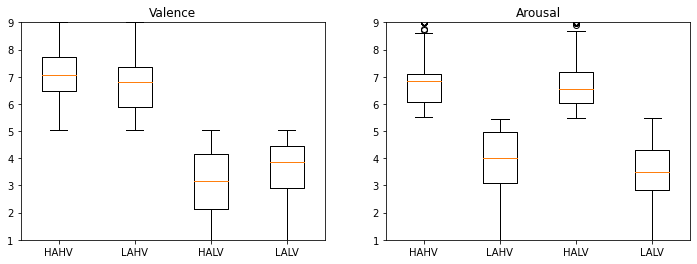

In [13]:
# Valence and Arousal ratings between groups
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].set_title("Valence")
axs[0].set_ylim(1, 9)
axs[0].boxplot([df_hahv['Valence'], df_lahv['Valence'], df_halv['Valence'], df_lalv['Valence']], labels=['HAHV','LAHV','HALV', 'LALV'])

axs[1].set_title("Arousal")
axs[1].set_ylim(1, 9)
axs[1].boxplot([df_hahv['Arousal'], df_lahv['Arousal'], df_halv['Arousal'], df_lalv['Arousal']], labels=['HAHV','LAHV','HALV', 'LALV'])

{'whiskers': [<matplotlib.lines.Line2D at 0x25300b55b80>,
 'caps': [<matplotlib.lines.Line2D at 0x25300b612e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x25300b557f0>,
 'medians': [<matplotlib.lines.Line2D at 0x25300b61a00>,
 'fliers': [<matplotlib.lines.Line2D at 0x25300b61d90>,
 'means': []}

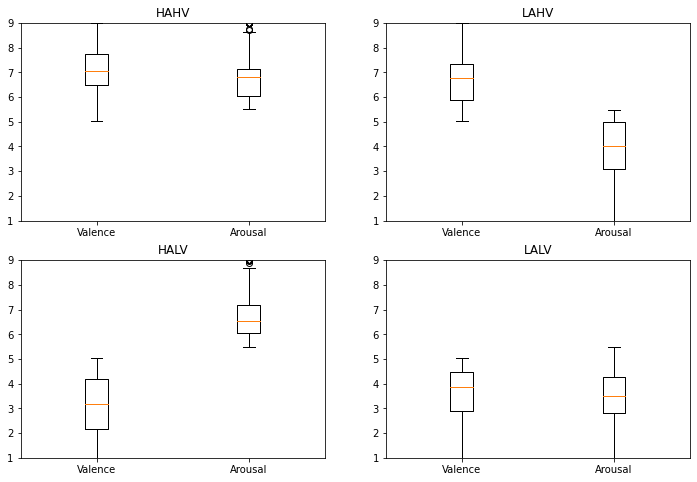

In [14]:
# Valence and Arousal ratings per group
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].set_title("HAHV")
axs[0,0].set_ylim(1, 9)
axs[0,0].boxplot([df_hahv['Valence'], df_hahv['Arousal']], labels=['Valence','Arousal'])

axs[0,1].set_title("LAHV")
axs[0,1].set_ylim(1, 9)
axs[0,1].boxplot([df_lahv['Valence'], df_lahv['Arousal']], labels=['Valence','Arousal'])

axs[1,0].set_title("HALV")
axs[1,0].set_ylim(1, 9)
axs[1,0].boxplot([df_halv['Valence'], df_halv['Arousal']], labels=['Valence','Arousal'])

axs[1,1].set_title("LALV")
axs[1,1].set_ylim(1, 9)
axs[1,1].boxplot([df_lalv['Valence'], df_lalv['Arousal']], labels=['Valence','Arousal'])

#### One hot encoding

In [15]:
# Function to check if each trial has positive or negative valence
def positive_valence(trial):
    return 1 if labels[trial,0] >= np.median(labels[:,0]) else 0 
# Function to check if each trial has high or low arousal
def high_arousal(trial):
    return 1 if labels[trial,1] >= np.median(labels[:,1]) else 0

In [16]:
# Convert all ratings to boolean values
labels_encoded = []
for i in range (len(labels)):
  labels_encoded.append([positive_valence(i), high_arousal(i)])
labels_encoded = np.reshape(labels_encoded, (880, 2))
df_labels = pd.DataFrame(data=labels_encoded, columns=["Positive Valence", "High Arousal"])
print(df_labels.describe())

       Positive Valence  High Arousal
count        880.000000    880.000000
mean           0.519318      0.502273
std            0.499911      0.500279
min            0.000000      0.000000
25%            0.000000      0.000000
50%            1.000000      1.000000
75%            1.000000      1.000000
max            1.000000      1.000000


In [17]:
# Dataset with only Valence column
df_valence = df_labels['Positive Valence']
# Dataset with only Arousal column
df_arousal = df_labels['High Arousal']

# MNE test

In [14]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [15]:
eeg_data = []
for i in range (len(data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(880, 32, 8064)


In [36]:
info = mne.create_info(eeg_channels.tolist(), ch_types=32*['eeg'], sfreq=128)
info.set_montage('standard_1020')
print(info)
raw_data = mne.io.RawArray(eeg_data[0], info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>
Creating RawArray with float64 data, n_channels=32, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.1s.
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\thiag\AppData\Local\Temp/ipykernel_9224/1765961710.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Not setting metadata
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


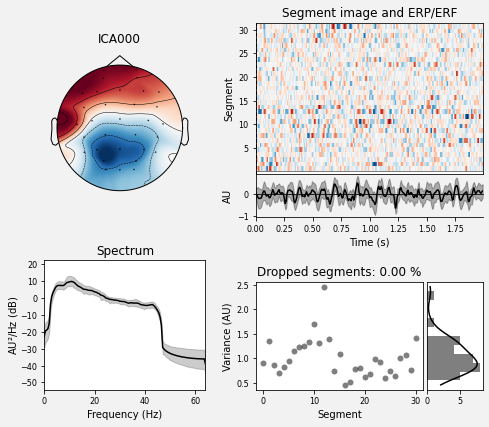

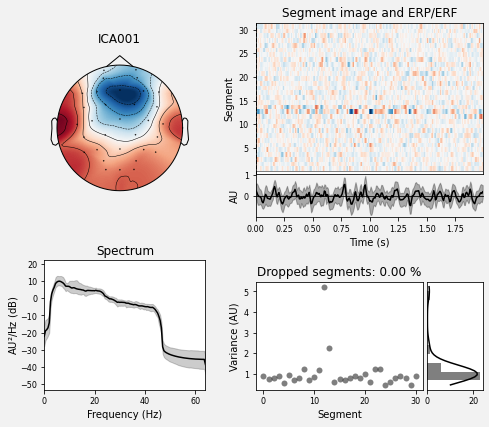

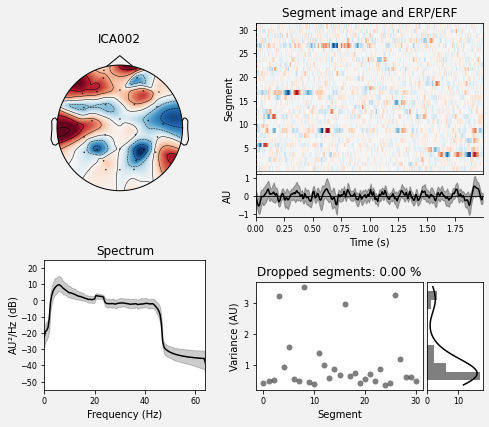

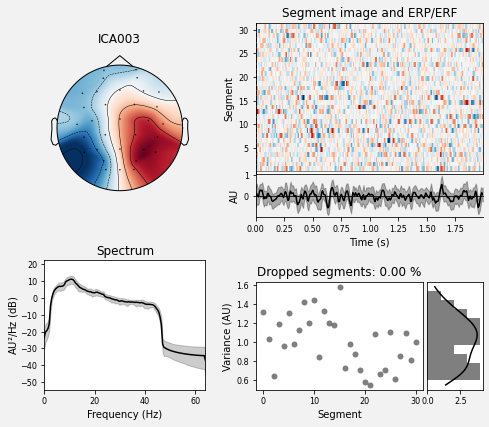

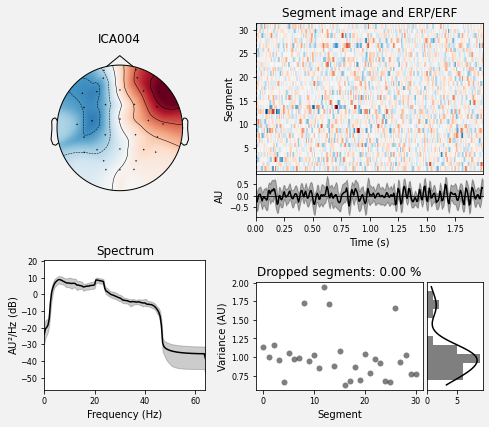

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [40]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=8, random_state=97, max_iter=800)
ica.fit(raw_data)
ica.plot_properties(raw_data)

## EEG data

### Separate EEG and non-EEG data

The dataset includes 32 EEG channels and 8 peripheral physiological channels. The peripheral signals include: electrooculogram (EOG), electromyograms (EMG) of Zygomaticus and Trapezius muscles, GSR, respiration amplitude, blood volume by plethysmograph, skin temperature.

In [18]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [19]:
eeg_data = []
for i in range (len(data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(880, 32, 8064)


In [20]:
peripheral_data = []
for i in range (len(data)):
  for j in range (32,len(data[0])):
    peripheral_data.append(data[i,j])
peripheral_data = np.reshape(peripheral_data, (len(data), len(peripheral_channels), len(data[0,0])))
print(peripheral_data.shape)

(880, 8, 8064)


### Welch's feature extraction

For the EEG data, we use Welch's method to extract theta, alpha, beta, and gamma spectral
power for each electrode. The frequency bands used:
theta (4 - 8 Hz), alpha (8 - 12 Hz), beta (12 - 30 Hz),
and gamma (30 - 64 Hz).

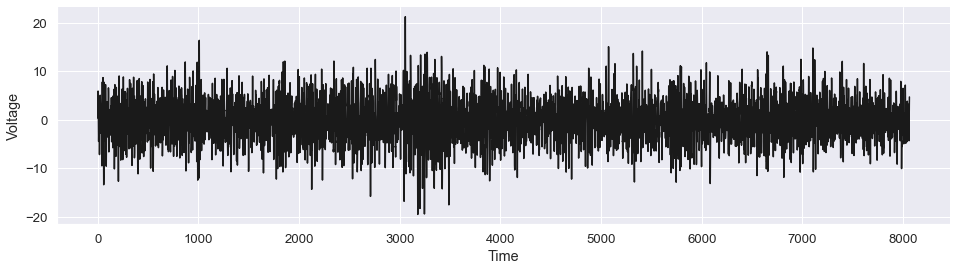

In [21]:
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 128.
time = np.arange(eeg_data.size) / sf

# Plot the signal of first trial, last channel 
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(eeg_data[0,31], lw=1.5, color='k') 
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

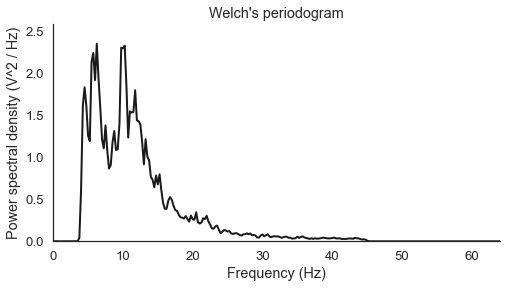

In [22]:
# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(eeg_data[0,31], sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

#### Theta band power

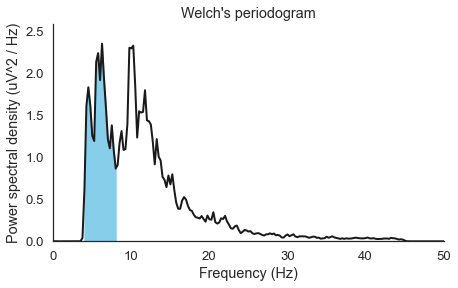

In [23]:
# Define theta lower and upper limits
low, high = 4, 8

# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the theta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_theta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Alpha band power

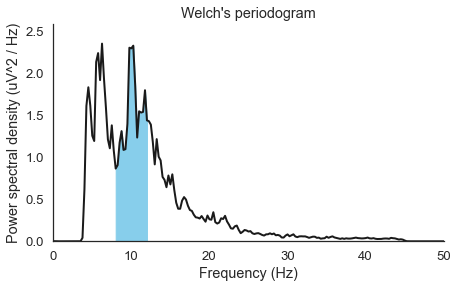

In [24]:
# Define alpha lower and upper limits
low, high = 8, 12

# Find intersecting values in frequency vector
idx_alpha = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the alpha area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_alpha, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Beta band power

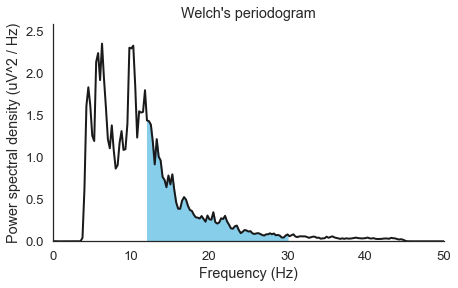

In [25]:
# Define beta lower and upper limits
low, high = 12, 30

# Find intersecting values in frequency vector
idx_beta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the beta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_beta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Gamma band power

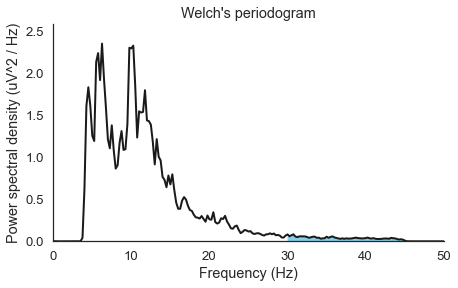

In [26]:
# Define delta lower and upper limits
low, high = 30, 64

# Find intersecting values in frequency vector
idx_gamma = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the gamma area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_gamma, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Functions to get band power values

In [27]:
"""Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
def bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [28]:
def get_band_power(trial, channel, band):
  bd = (0,0)

  if (band == "theta"): # drownsiness, emotional connection, intuition, creativity
    bd = (4,8)
  elif (band == "alpha"): # reflection, relaxation
    bd = (8,12)
  elif (band == "beta"): # concentration, problem solving, memory
    bd = (12,30)
  elif (band == "gamma"): # cognition, perception, learning, multi-tasking
    bd = (30,64)
  
  return bandpower(eeg_data[trial,channel], 128, bd)

print(get_band_power(0,31,"theta"))
print(get_band_power(0,31,"alpha"))
print(get_band_power(0,31,"beta"))
print(get_band_power(0,31,"gamma"))

5.434119660168186
5.369595513295194
6.286556266834863
0.9879159580139809


### Create EEG plots

#### General plots

In [29]:
info = mne.create_info(32, sfreq=128)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 32 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [13]:
info = mne.create_info(eeg_channels.tolist(), ch_types=32*['eeg'], sfreq=128)
info.set_montage('standard_1020')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [31]:
raw_data = mne.io.RawArray(eeg_data[31], info)

Creating RawArray with float64 data, n_channels=32, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.


Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


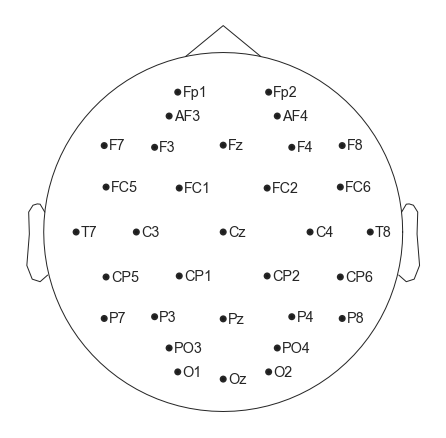

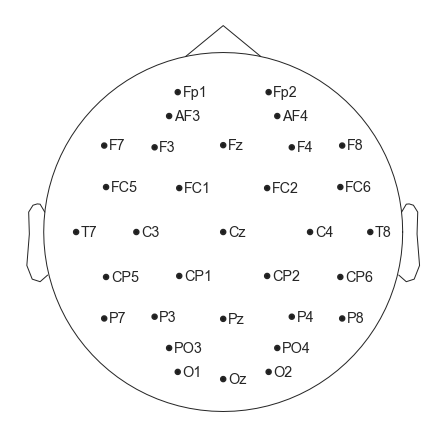

In [32]:
# Plot sensor positions
montage = mne.channels.make_standard_montage("biosemi32")
raw_data.set_montage(montage)
montage.plot()

Effective window size : 16.000 (s)


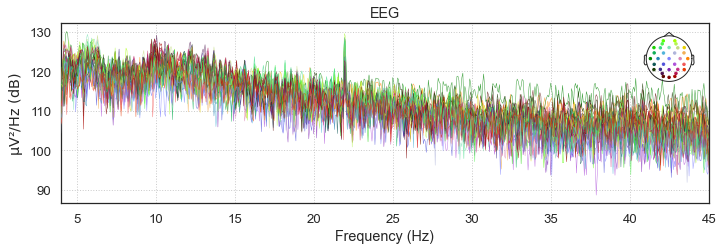

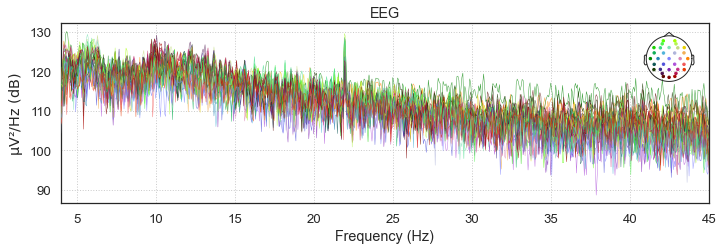

In [33]:
# Plot the power spectral density across channels
mne.viz.plot_raw_psd(raw_data, fmin = 4, fmax= 45)

#### Topomaps for each band of frequencies

Following this thread: https://mail.nmr.mgh.harvard.edu/pipermail//mne_analysis/2019-April/005812.html

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



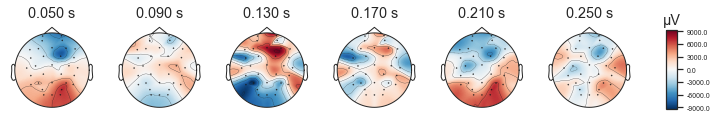

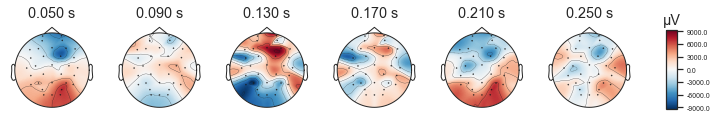

In [34]:
# Theta band, first trial
evData_th = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_th.filter(4, 8) 
evData_th.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



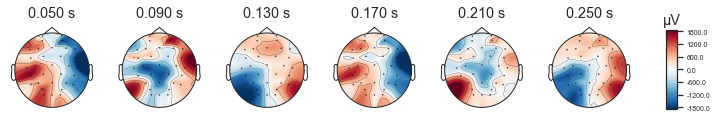

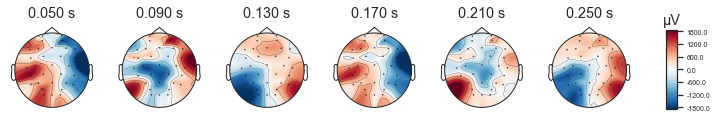

In [35]:
# Alpha band, first trial
evData_al = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_al.filter(8, 12) 
evData_al.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



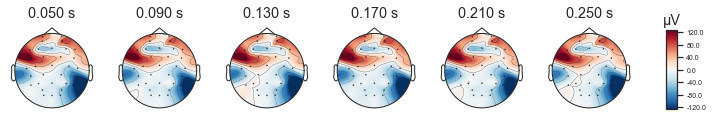

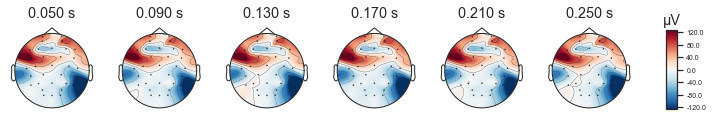

In [36]:
# Beta band, first trial
evData_bt = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_bt.filter(12, 30) 
evData_bt.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



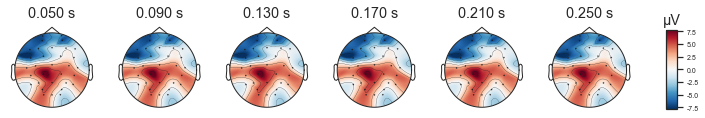

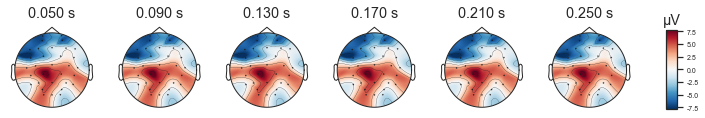

In [37]:
# Gamma band, first trial
evData_gm = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_gm.filter(30, 63.9) 
evData_gm.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

#### Topomaps of subjects from HAHV - HALV - LAHV - LALV groups

In [38]:
# Getting samples from 4 label groups, same subject
ev_data_hahv = mne.EvokedArray(eeg_data[1], info)
ev_data_halv = mne.EvokedArray(eeg_data[14], info)
ev_data_lahv = mne.EvokedArray(eeg_data[6], info)
ev_data_lalv = mne.EvokedArray(eeg_data[9], info)

In [39]:
# Plot the topographies across different frequency bands
def plot_topo_psd(evData):
  evData.filter(4, 8) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

  evData.filter(8, 12) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

  evData.filter(12, 30) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

  evData.filter(30, 63.9) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



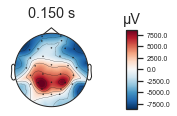

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



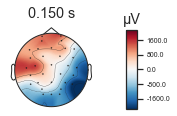

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



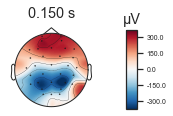

Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



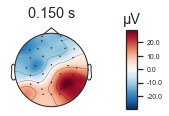

In [40]:
plot_topo_psd(ev_data_hahv)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



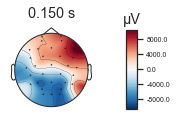

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



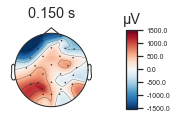

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



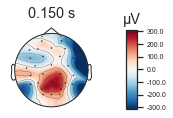

Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



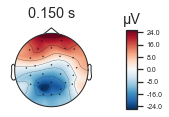

In [41]:
plot_topo_psd(ev_data_halv)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



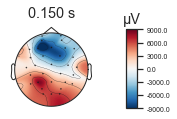

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



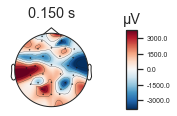

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



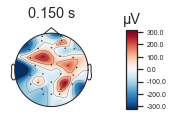

Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



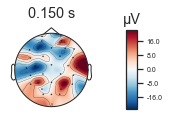

In [42]:
plot_topo_psd(ev_data_lahv)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



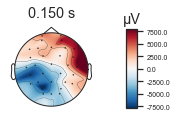

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



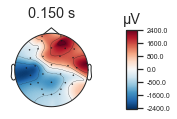

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



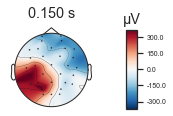

Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



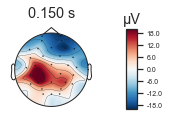

In [43]:
plot_topo_psd(ev_data_lalv)

#### Topomaps of subjects from HAHV - HALV - LAHV - LALV groups by FOOOF

This will help plotting topomaps of all bands with the same scale of power spectra.

In [44]:
# Deal with NaN values when the model cannot detect peaks in any given range
def check_nans(data, nan_policy='zero'):
    """Check an array for nan values, and replace, based on policy."""
    # Find where there are nan values in the data
    nan_inds = np.where(np.isnan(data))
    # Apply desired nan policy to data
    if nan_policy == 'zero':
        data[nan_inds] = 0
    elif nan_policy == 'mean':
        data[nan_inds] = np.nanmean(data)
    else:
        raise ValueError('Nan policy not understood.')
    return data

In [45]:
# Plot the topographies across different frequency bands
def plot_psd_fooof(evData):
  fg = FOOOFGroup(peak_width_limits=[1, 6], min_peak_height=0.05, peak_threshold=2., max_n_peaks=6, verbose=False)
  bands = Bands({'theta': [4, 8],'alpha': [8, 12],'beta': [12, 30],'gamma': [30, 64]})
  freq_range = [1, 128]
  # Calculate power spectra across the the continuous data by MNE
  spectra, freqs = psd_welch(evData, fmin=1, fmax=128, tmin=0, tmax=250, n_overlap=150, n_fft=300)
  fg.fit(freqs, spectra, freq_range)
  # Plot the topographies across different frequency bands
  fig, axes = plt.subplots(1, 4, figsize=(20, 5))
  for ind, (label, band_def) in enumerate(bands):
      # Extract the power peaks across channels for the current band
      band_power = check_nans(get_band_peak_fg(fg, band_def)[:, 1])
      # Create a topomap for the current oscillation band
      mne.viz.plot_topomap(band_power, evData.info, cmap=cm.viridis, axes=axes[ind], show=False);
      axes[ind].set_title(label + ' power', {'fontsize' : 16})

In [46]:
def plot_psd_peak(evData):
  fg = FOOOFGroup(peak_width_limits=[1, 6], min_peak_height=0.05, peak_threshold=2., max_n_peaks=6, verbose=False)
  bands = Bands({'theta': [4, 8],'alpha': [8, 12],'beta': [12, 30],'gamma': [30, 64]})
  freq_range = [1, 128]
  # Calculate power spectra across the the continuous data by MNE
  spectra, freqs = psd_welch(evData, fmin=1, fmax=128, tmin=0, tmax=250, n_overlap=150, n_fft=300)
  fg.fit(freqs, spectra, freq_range)
  # Check the largest detected peaks within each band
  fig, axes = plt.subplots(1, 4, figsize=(20, 6))
  for ind, (label, band_def) in enumerate(bands):
      # Get the power values across channels for the current band
      band_power = check_nans(get_band_peak_fg(fg, band_def)[:, 1])
      # Extracted and plot the power spectrum model with the most band power
      fg.get_fooof(np.argmax(band_power)).plot(ax=axes[ind], add_legend=False)
      axes[ind].yaxis.set_ticklabels([])
      axes[ind].set_title('biggest ' + label + ' peak', {'fontsize' : 16})

Effective window size : 2.344 (s)


C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarra

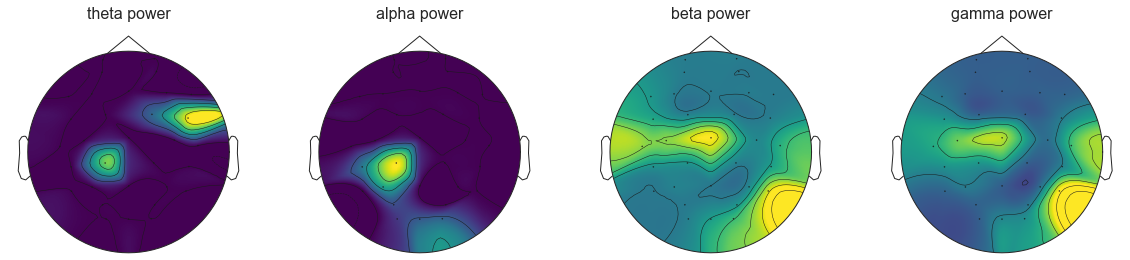

In [47]:
plot_psd_fooof(ev_data_hahv)

Effective window size : 2.344 (s)


C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarra

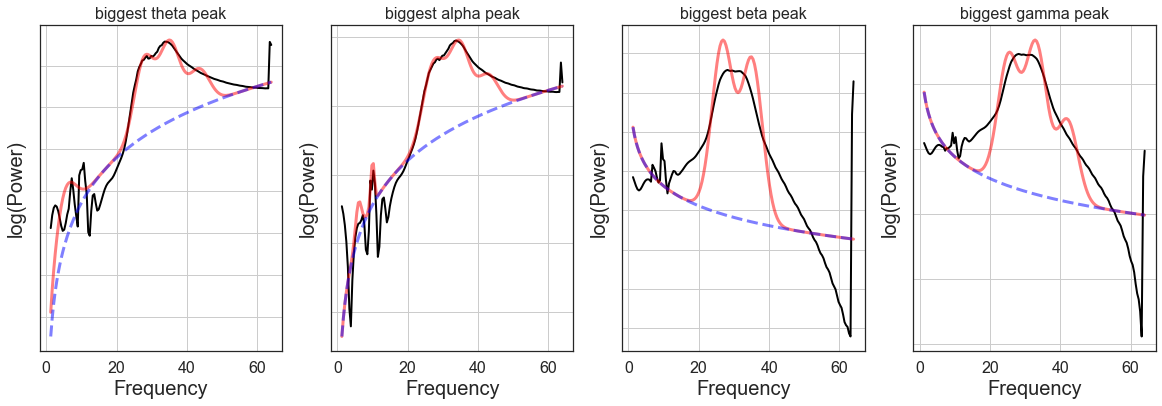

In [48]:
plot_psd_peak(ev_data_hahv)

Effective window size : 2.344 (s)


C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarra

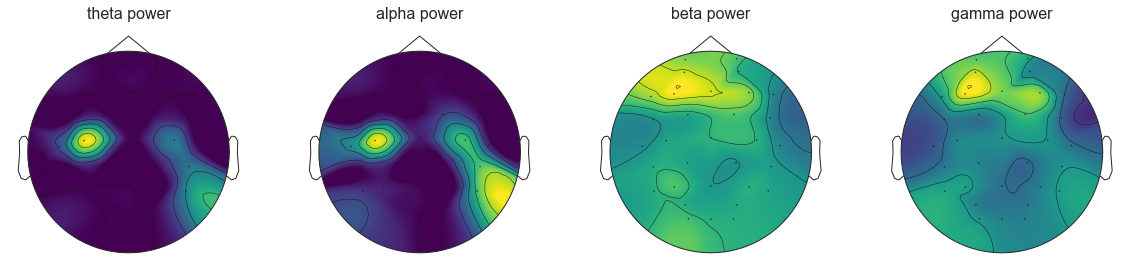

In [49]:
plot_psd_fooof(ev_data_halv)

Effective window size : 2.344 (s)


C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarra

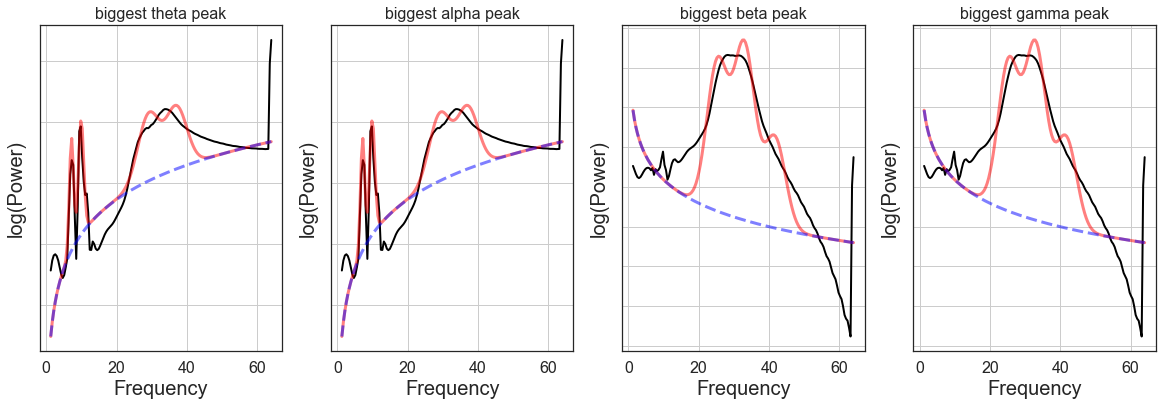

In [50]:
plot_psd_peak(ev_data_halv)

Effective window size : 2.344 (s)


C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarra

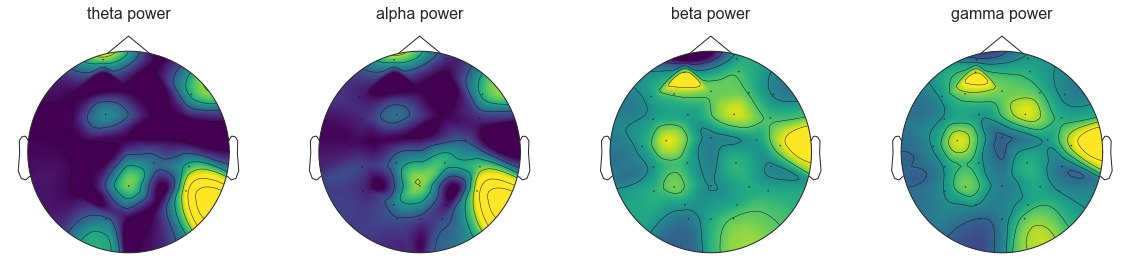

In [51]:
plot_psd_fooof(ev_data_lahv)

Effective window size : 2.344 (s)


C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarra

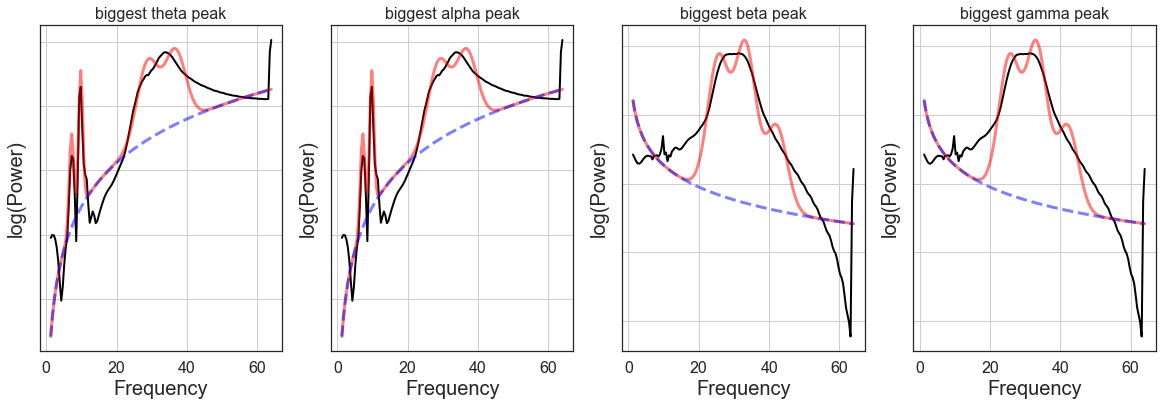

In [52]:
plot_psd_peak(ev_data_lahv)

Effective window size : 2.344 (s)


C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarra

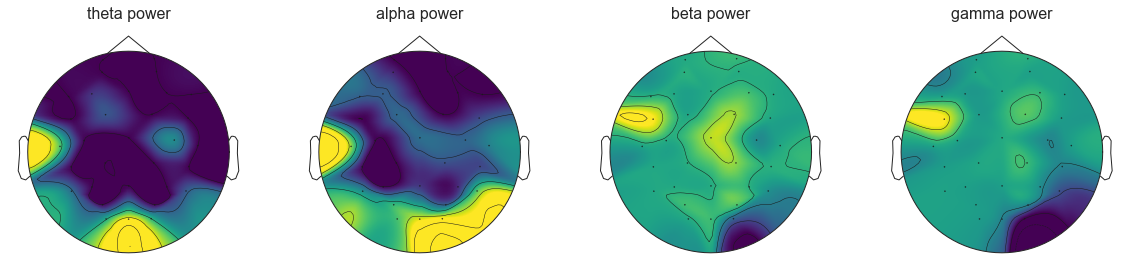

In [53]:
plot_psd_fooof(ev_data_lalv)

Effective window size : 2.344 (s)


C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
C:\Users\thiag\anaconda3\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarra

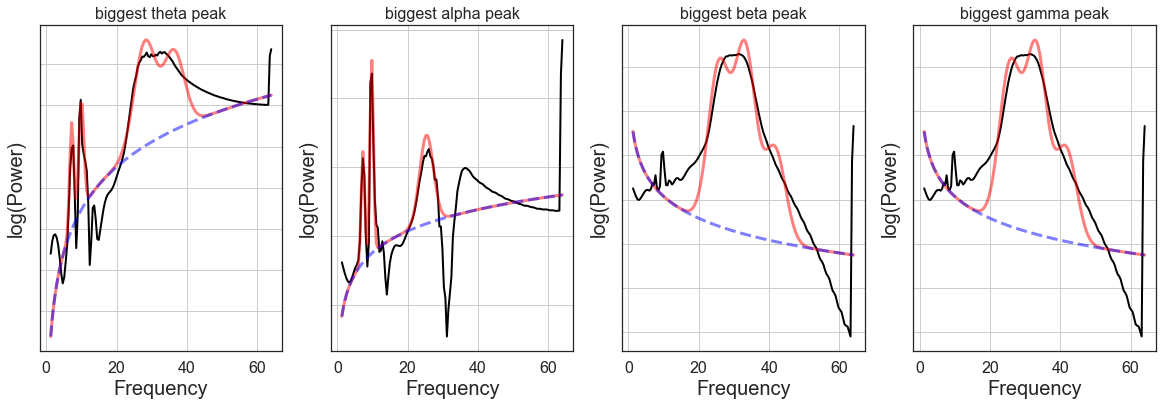

In [54]:
plot_psd_peak(ev_data_lalv)

### Process new datasets with 6 EEG regions and 4 band power values

In [55]:
# Transform 880 x 32 x 8064 => 880 x 128
eeg_band_arr = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_band_arr.append(get_band_power(i,j,"theta"))
    eeg_band_arr.append(get_band_power(i,j,"alpha"))
    eeg_band_arr.append(get_band_power(i,j,"beta"))
    eeg_band_arr.append(get_band_power(i,j,"gamma"))
eeg_band_arr = np.reshape(eeg_band_arr, (880, 128))

EEG channels are divided into 6 groups, according to their cerebral spatial locations. We combine the temmporal-left and temporal-right channels into the left and right groups. The frontal group only includes the fronto-central channels. All centro-parietal channels are included in the central group.

In [56]:
left = np.array(["Fp1", "AF3", "F7", "FC5", "T7"])
right = np.array(["Fp2", "AF4", "F8", "FC6", "T8"])
frontal = np.array(["F3", "FC1", "Fz", "F4", "FC2"])
parietal = np.array(["P3", "P7", "Pz", "P4", "P8"])
occipital = np.array(["O1", "Oz", "O2", "PO3", "PO4"])
central = np.array(["CP5", "CP1", "Cz", "C4", "C3", "CP6", "CP2"])

#### Dataframe for Theta power values

In [57]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_theta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_theta.append(get_band_power(i,j,"theta"))
eeg_theta = np.reshape(eeg_theta, (880, 32))

df_theta = pd.DataFrame(data = eeg_theta, columns=eeg_channels)
print(df_theta.describe())

                Fp1           AF3            F3            F7           FC5  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   5.476747e+02  1.275351e+03  9.614382e+02  2.081203e+03  9.465240e+02   
std    1.217600e+03  3.736193e+03  3.558854e+03  5.918715e+03  2.572982e+03   
min    2.895855e-12  5.217485e-12  8.531922e-12  1.108519e-11  4.114167e-12   
25%    2.409321e+01  1.860138e+01  2.204631e+01  3.912328e+01  1.387218e+01   
50%    5.845061e+01  7.275575e+01  7.399130e+01  1.053462e+02  4.300044e+01   
75%    3.662748e+02  3.134779e+02  1.963466e+02  2.787570e+02  2.560120e+02   
max    1.552414e+04  3.812287e+04  3.943132e+04  4.927279e+04  2.018267e+04   

                FC1            C3            T7           CP5           CP1  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   3.356400e+02  6.296681e+02  3.841360e+02  4.374546e+02  2.786658e+02   
std    7.140925e+02  1.774593e+03  6.900685e+02  1.

In [58]:
# Only print central channels
print(df_theta[central].head(5)) 

            CP5           CP1            Cz            C4            C3  \
0  2.881030e-12  1.102969e-11  7.516943e-12  2.045050e-12  4.197735e-12   
1  3.869735e-11  3.822071e-11  3.480808e-12  3.943074e-12  5.063776e-11   
2  3.711943e+00  1.890259e+00  2.386166e+00  3.942938e+00  4.284358e+00   
3  4.004765e+00  1.883543e+00  7.414694e+00  3.498076e+00  4.171965e+00   
4  1.857737e+00  1.447578e+00  1.993286e+00  1.803010e+00  1.798486e+00   

            CP6           CP2  
0  3.026707e-12  3.933774e-12  
1  2.117855e-11  6.831691e-12  
2  2.503685e+00  1.974655e+00  
3  2.529543e+00  1.736048e+00  
4  1.496299e+00  1.577524e+00  


#### Dataframe for Alpha power values

In [59]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_alpha = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_alpha.append(get_band_power(i,j,"alpha"))
eeg_alpha = np.reshape(eeg_alpha, (880, 32))

df_alpha = pd.DataFrame(data = eeg_alpha, columns=eeg_channels)
print(df_alpha.describe())

                Fp1           AF3            F3            F7           FC5  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   1.827583e+02  4.329846e+02  3.417030e+02  7.873711e+02  3.147217e+02   
std    3.976195e+02  1.257601e+03  1.216980e+03  2.308054e+03  8.258155e+02   
min    8.517343e-12  2.410982e-11  4.107240e-11  4.240856e-11  7.586702e-12   
25%    1.419147e+01  1.160664e+01  1.198029e+01  2.027352e+01  1.002601e+01   
50%    3.325528e+01  3.057807e+01  3.480832e+01  4.343559e+01  1.869576e+01   
75%    1.431223e+02  1.132199e+02  7.668653e+01  9.853214e+01  8.089379e+01   
max    5.627907e+03  1.238070e+04  1.276472e+04  2.084307e+04  6.575781e+03   

                FC1            C3            T7           CP5           CP1  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   1.212650e+02  2.177801e+02  1.345378e+02  1.526536e+02  9.738677e+01   
std    2.395057e+02  5.892251e+02  2.123138e+02  4.

In [60]:
# Only print occipital channels
print(df_alpha[occipital].head(5)) 

             O1            Oz            O2           PO3           PO4
0  1.958276e-11  1.063586e-11  1.475856e-11  2.995791e-11  2.110533e-11
1  4.541230e-11  5.876929e-11  1.456718e-10  1.336689e-10  2.411633e-10
2  6.263437e+00  5.958844e+00  8.209320e+00  7.656804e+00  9.179372e+00
3  5.632504e+00  5.341003e+00  6.541218e+00  6.627711e+00  6.922430e+00
4  4.457119e+00  4.057350e+00  5.195625e+00  5.767454e+00  5.225959e+00


#### Dataframe for Beta power values

In [61]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_beta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_beta.append(get_band_power(i,j,"beta"))
eeg_beta = np.reshape(eeg_beta, (880, 32))

df_beta = pd.DataFrame(data = eeg_beta, columns=eeg_channels)
print(df_beta.describe())

                Fp1           AF3            F3            F7           FC5  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   1.015774e+02  2.639131e+02  2.354640e+02  4.653608e+02  1.797685e+02   
std    1.983515e+02  7.964053e+02  7.883804e+02  1.519033e+03  4.581587e+02   
min    2.388058e-10  9.313548e-09  5.034426e-09  7.639419e-09  4.872687e-09   
25%    1.808682e+01  1.198300e+01  1.072901e+01  2.209180e+01  1.120456e+01   
50%    3.472251e+01  2.512552e+01  3.628217e+01  3.828849e+01  2.447575e+01   
75%    8.583555e+01  1.269000e+02  6.071346e+01  6.669544e+01  5.144377e+01   
max    3.528485e+03  5.784160e+03  5.841476e+03  1.484870e+04  3.094688e+03   

                FC1            C3            T7           CP5           CP1  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   7.904511e+01  1.223781e+02  8.830371e+01  1.005122e+02  5.609785e+01   
std    1.430195e+02  2.926379e+02  9.904145e+01  3.

In [62]:
# Only print frontal channels
print(df_beta[frontal].head(5)) 

             F3           FC1            Fz            F4           FC2
0  1.064947e-08  5.310574e-09  2.966548e-09  1.301296e-09  1.937739e-09
1  3.288307e-08  2.519619e-08  3.693918e-08  4.365469e-08  2.993975e-08
2  9.839357e+00  4.390210e+00  7.598063e+00  9.444911e+00  6.377253e+00
3  7.032711e+00  3.946574e+00  6.481246e+00  6.763315e+00  5.341841e+00
4  6.021147e+00  3.145262e+00  5.356596e+00  5.797735e+00  4.608033e+00


#### Dataframe for Gamma power values

In [63]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_gamma = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_gamma.append(get_band_power(i,j,"gamma"))
eeg_gamma = np.reshape(eeg_gamma, (880, 32))

df_gamma = pd.DataFrame(data = eeg_gamma, columns=eeg_channels)
print(df_gamma.describe())

                Fp1           AF3            F3            F7           FC5  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   6.435339e+01  2.096995e+02  1.946003e+02  1.599305e+02  1.241909e+02   
std    1.612193e+02  7.714513e+02  7.533771e+02  5.928338e+02  4.064010e+02   
min    5.683412e-09  8.261575e-08  6.465818e-08  1.371773e-07  4.939536e-08   
25%    9.012946e+00  5.500269e+00  5.077370e+00  1.119272e+01  5.261965e+00   
50%    2.067978e+01  1.455904e+01  1.540315e+01  1.849035e+01  1.354138e+01   
75%    4.835953e+01  7.474244e+01  3.809379e+01  4.398563e+01  4.454889e+01   
max    3.213256e+03  6.060540e+03  5.758757e+03  6.348177e+03  3.472516e+03   

                FC1            C3            T7           CP5           CP1  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   5.618456e+01  7.456514e+01  5.326980e+01  8.052702e+01  3.272222e+01   
std    1.412331e+02  2.143452e+02  7.125322e+01  2.

In [64]:
# Only print parietal channels
print(df_gamma[parietal].head(5)) 

             P3            P7            Pz            P4            P8
0  1.807680e-08  1.430477e-08  4.173796e-08  6.907498e-08  6.513504e-08
1  9.428286e-07  1.790268e-07  2.180208e-07  1.251983e-06  8.399015e-07
2  1.405996e+00  2.340776e+00  6.149348e-01  1.759804e+00  1.651851e+00
3  1.127093e+00  1.381447e+00  5.556367e-01  1.406085e+00  8.040019e-01
4  1.031171e+00  1.626731e+00  5.353514e-01  1.275852e+00  1.514359e+00


# Train-test split and feature scaling

In [65]:
# Split the data into training/testing sets
def split_train_test(x, y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
  return x_train, x_test, y_train, y_test

In [66]:
# Feature scaling
def feature_scaling(train, test):
  sc = StandardScaler()
  train = sc.fit_transform(train)
  test = sc.transform(test)
  return train, test

# Cross-validation to select classifier

In [67]:
band_names = np.array(["theta", "alpha", "beta", "gamma"])
channel_names = np.array(["left", "frontal", "right", "central", "parietal", "occipital"])
label_names = np.array(["valence", "arousal"])

In [68]:
# Testing different kernels (linear, sigmoid, rbf, poly) to select the most optimal one
clf_svm = SVC(kernel = 'linear', random_state = 42, probability=True)

In [69]:
# Testing different k (odd) numbers, algorithm (auto, ball_tree, kd_tree) and weight (uniform, distance) to select the most optimal one
clf_knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto')

In [70]:
# Testing different learning rate (alpha), solver (adam, sgd, lbfgs) and activation (relu, tanh, logistic) to select the most optimal one
clf_mlp = MLPClassifier(solver='adam', activation='tanh', alpha=0.3, max_iter=400)

In [71]:
models = []
models.append(('SVM', clf_svm))
models.append(('k-NN', clf_knn))
models.append(('MLP', clf_mlp))

In [72]:
import time
def cross_validate_clf(df_x, df_y, scoring):
  # Train-test split 
  x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)
  # Feature scaling
  x_train, x_test = feature_scaling(x_train, x_test)

  names = []
  means = []
  stds = []
  times = []

  # Apply CV
  for name, model in models:
      start_time = time.time()
      kfold = model_selection.KFold(n_splits=5)
      cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
      t = (time.time() - start_time)
      times.append(t)
      means.append(cv_results.mean())
      stds.append(cv_results.std())
      names.append(name)

  return names, means, stds, times

### Arousal - Accuracy

In [73]:
cross_validate_clf(eeg_band_arr, df_arousal, 'accuracy')

(['SVM', 'k-NN', 'MLP'],
 [0.5843692630474692, 0.5778258589037504, 0.6087070548124836],
 [0.032803098748839236, 0.04320218476063625, 0.028135572932913896],
 [0.6263551712036133, 0.021908998489379883, 7.324799299240112])

### Arousal - F1

In [74]:
cross_validate_clf(eeg_band_arr, df_arousal, 'f1')

(['SVM', 'k-NN', 'MLP'],
 [0.5960453014998469, 0.5833709946418661, 0.5961481543265224],
 [0.06255872576643338, 0.05391467878516152, 0.04624599740377395],
 [0.6329193115234375, 0.021943330764770508, 6.00750470161438])

### Valence - Accuracy

In [75]:
cross_validate_clf(eeg_band_arr, df_valence, 'accuracy')

C:\Users\thiag\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


(['SVM', 'k-NN', 'MLP'],
 [0.5780881195908733, 0.6168895882507213, 0.6235116706005769],
 [0.055211667742540715, 0.04800198845377898, 0.07658034966859832],
 [0.8078408241271973, 0.02194070816040039, 7.143908262252808])

### Valence - F1

In [76]:
cross_validate_clf(eeg_band_arr, df_valence, 'f1')

(['SVM', 'k-NN', 'MLP'],
 [0.568831883151483, 0.6273460955324547, 0.6394544320576468],
 [0.054174021396036345, 0.06063848893766251, 0.1009260082233974],
 [0.7360608577728271, 0.021913528442382812, 6.022967100143433])

# Apply classifier

## Functions to run classifiers

In [77]:
def run_clf_cv(band, channel, label, clf):
  if (band == "theta"):
    df_x = df_theta
  elif (band == "alpha"):
    df_x = df_alpha
  elif (band == "beta"):
    df_x = df_beta
  elif (band == "gamma"):
    df_x = df_gamma

  if (channel == "left"):
    df_x = df_x[left]
  elif (channel == "right"):
    df_x = df_x[right]
  elif (channel == "frontal"):
    df_x = df_x[frontal]
  elif (channel == "central"):
    df_x = df_x[central]
  elif (channel == "parietal"):
    df_x = df_x[parietal]
  elif (channel == "occipital"):
    df_x = df_x[occipital]

  df_y = df_arousal if (label == "arousal") else df_valence

  # Train-test split
  x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)
  
  # Apply CV
  x_for_kfold = np.array(x_train)            
  y_for_kfold = np.array(y_train)
  kfold = model_selection.KFold(n_splits=5)

  for i, j in kfold.split(x_for_kfold):
   x_train2, x_test2 = x_for_kfold[i], x_for_kfold[j]
   y_train2, y_test2 = y_for_kfold[i], y_for_kfold[j]
  
  # Feature scaling
  x_train2, x_test2 = feature_scaling(x_train2, x_test2)

  if (clf == "svm"):
    clf_svm.fit(x_train2, y_train2)
    y_predict = clf_svm.predict(x_test2)
  elif (clf == "knn"):
    clf_knn.fit(x_train2, y_train2)
    y_predict = clf_knn.predict(x_test2)
  elif (clf == "mlp"):
    clf_mlp.fit(x_train2, y_train2)
    y_predict = clf_mlp.predict(x_test2)

  return y_test2, y_predict

In [78]:
def get_accuracy(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  return np.round(accuracy_score(y_test2, y_predict)*100,2)

In [79]:
def print_accuracy(label, clf):
  arr = []
  for i in range (len(band_names)):
    for j in range (len(channel_names)): 
      arr.append(get_accuracy(band_names[i], channel_names[j], label, clf))
  arr = np.reshape(arr, (4,6))
  df = pd.DataFrame(data = arr, index=band_names, columns=channel_names)

  print("Top 3 EEG regions with highest scores")
  print(df.apply(lambda s: s.abs()).max().nlargest(3))
  print()
  print("Top 2 bands with highest scores")
  print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
  print()
  print("EEG region with highest scores per each band")
  print(df.idxmax(axis=1))
  print()
  print("Band with highest scores per each EEG region")
  print(df.idxmax())
  print()
  print(df)

In [80]:
def get_f1(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  return np.round(f1_score(y_test2, y_predict)*100,2)

In [81]:
def print_f1(label, clf):
  arr = []
  for i in range (len(band_names)):
    for j in range (len(channel_names)): 
      arr.append(get_f1(band_names[i], channel_names[j], label, clf))
  arr = np.reshape(arr, (4,6))
  df = pd.DataFrame(data = arr, index=band_names, columns=channel_names)

  print("Top 3 EEG regions with highest scores")
  print(df.apply(lambda s: s.abs()).max().nlargest(3))
  print()
  print("Top 2 bands with highest scores")
  print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
  print()
  print("EEG region with highest scores per each band")
  print(df.idxmax(axis=1))
  print()
  print("Band with highest scores per each EEG regions")
  print(df.idxmax())
  print()
  print(df)

In [82]:
def plot_cm(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  cm = confusion_matrix(y_test2, y_predict)
  print(cm)
  cr = classification_report(y_test2, y_predict)
  print(cr)

  plt.figure()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.colorbar()

  if (label == "valence"):
    classes = df_valence.unique().tolist()
  if (label == "arousal"):
    classes = df_arousal.unique().tolist()

  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


## Accuracy results

### Valence

In [83]:
# Only use k-NN in case of Valence after CV
print_accuracy('valence', 'knn')

Top 3 EEG regions with highest scores
left       69.11
right      69.11
central    67.48
dtype: float64

Top 2 bands with highest scores
beta     69.11
gamma    69.11
dtype: float64

EEG region with highest scores per each band
theta    central
alpha    central
beta        left
gamma      right
dtype: object

Band with highest scores per each EEG region
left          beta
frontal       beta
right        gamma
central      theta
parietal      beta
occipital     beta
dtype: object

        left  frontal  right  central  parietal  occipital
theta  58.54    64.23  56.91    67.48     57.72      54.47
alpha  59.35    51.22  60.16    65.04     62.60      55.28
beta   69.11    65.04  66.67    60.98     65.85      64.23
gamma  60.16    60.98  69.11    61.79     60.98      62.60


### Arousal

In [84]:
# Only use MLP in case of Arousal after CV
print_accuracy('arousal', 'mlp')

Top 3 EEG regions with highest scores
parietal    60.98
left        60.16
central     58.54
dtype: float64

Top 2 bands with highest scores
theta    60.98
beta     60.98
dtype: float64

EEG region with highest scores per each band
theta    parietal
alpha     central
beta     parietal
gamma        left
dtype: object

Band with highest scores per each EEG region
left         gamma
frontal      theta
right        theta
central      theta
parietal     theta
occipital    alpha
dtype: object

        left  frontal  right  central  parietal  occipital
theta  52.03    56.10  51.22    58.54     60.98      51.22
alpha  54.47    54.47  51.22    58.54     57.72      52.03
beta   51.22    50.41  47.97    52.85     60.98      48.78
gamma  60.16    50.41  44.72    52.03     60.16      45.53


## F1 score results

### Valence

In [85]:
# Only use k-NN in case of Valence after CV
print_f1('valence', 'knn')

Top 3 EEG regions with highest scores
right      73.24
central    71.83
left       69.84
dtype: float64

Top 2 bands with highest scores
gamma    73.24
theta    71.83
dtype: float64

EEG region with highest scores per each band
theta    central
alpha    central
beta       right
gamma      right
dtype: object

Band with highest scores per each EEG regions
left          beta
frontal      theta
right        gamma
central      theta
parietal      beta
occipital     beta
dtype: object

        left  frontal  right  central  parietal  occipital
theta  61.65    69.44  61.31    71.83     61.76      58.82
alpha  62.12    53.12  64.23    68.61     65.67      58.65
beta   69.84    68.61  71.72    63.64     68.66      68.57
gamma  62.60    63.64  73.24    66.67     65.22      68.49


### Arousal

In [86]:
# Only use MLP in case of Arousal after CV
print_f1('arousal', 'mlp')

Top 3 EEG regions with highest scores
parietal     67.11
central      64.90
occipital    64.67
dtype: float64

Top 2 bands with highest scores
theta    67.11
alpha    64.86
dtype: float64

EEG region with highest scores per each band
theta     parietal
alpha      central
beta     occipital
gamma      central
dtype: object

Band with highest scores per each EEG regions
left         theta
frontal      alpha
right        theta
central      theta
parietal     theta
occipital    alpha
dtype: object

        left  frontal  right  central  parietal  occipital
theta  63.69    54.87  62.96    64.90     67.11      63.86
alpha  63.69    61.64  62.96    64.86     58.91      64.67
beta   50.85    58.57  59.63    60.81     55.65      63.03
gamma  56.36    55.17  53.33    59.31     54.87      46.38


## Plot results

#### Top combinations for Valence

[[32 21]
 [19 51]]
              precision    recall  f1-score   support

           0       0.63      0.60      0.62        53
           1       0.71      0.73      0.72        70

    accuracy                           0.67       123
   macro avg       0.67      0.67      0.67       123
weighted avg       0.67      0.67      0.67       123



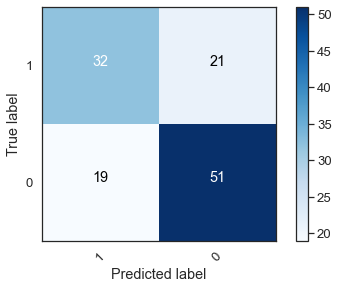

In [87]:
plot_cm('theta', 'central', 'valence', 'knn')

[[41 12]
 [26 44]]
              precision    recall  f1-score   support

           0       0.61      0.77      0.68        53
           1       0.79      0.63      0.70        70

    accuracy                           0.69       123
   macro avg       0.70      0.70      0.69       123
weighted avg       0.71      0.69      0.69       123



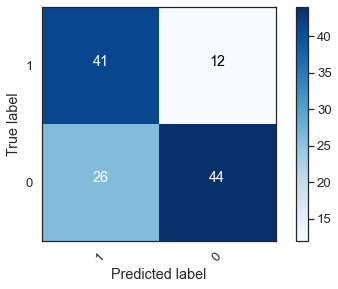

In [88]:
plot_cm('beta', 'left', 'valence', 'knn')

[[33 20]
 [18 52]]
              precision    recall  f1-score   support

           0       0.65      0.62      0.63        53
           1       0.72      0.74      0.73        70

    accuracy                           0.69       123
   macro avg       0.68      0.68      0.68       123
weighted avg       0.69      0.69      0.69       123



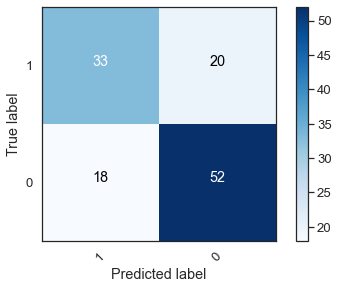

In [89]:
plot_cm('gamma', 'right', 'valence', 'knn')

#### Top combinations for Arousal

[[21 40]
 [12 50]]
              precision    recall  f1-score   support

           0       0.64      0.34      0.45        61
           1       0.56      0.81      0.66        62

    accuracy                           0.58       123
   macro avg       0.60      0.58      0.55       123
weighted avg       0.60      0.58      0.55       123



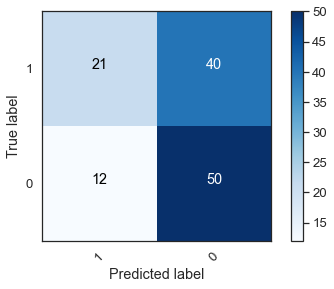

In [90]:
plot_cm('alpha', 'central', 'arousal', 'mlp')

[[26 35]
 [14 48]]
              precision    recall  f1-score   support

           0       0.65      0.43      0.51        61
           1       0.58      0.77      0.66        62

    accuracy                           0.60       123
   macro avg       0.61      0.60      0.59       123
weighted avg       0.61      0.60      0.59       123



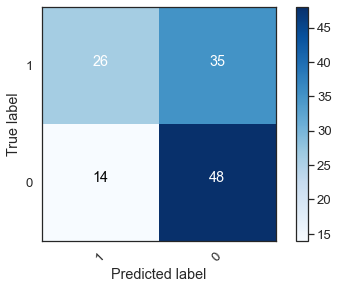

In [91]:
plot_cm('theta', 'parietal', 'arousal', 'mlp')